# Tool Window Usage Analysis

This notebook analyzes IDE tool window open/close logs to find out
whether automatically opened tool windows stay open longer than manual ones.

##  How to Set Up and Run the Code
1. Open this notebook in Google Colab.
2. Upload  `toolwindow_data.csv` dataset.
3. Run the notebook step by step.

## Step 1: Load and Prepare the Data

We first import the necessary libraries, load the dataset and sort it by `user_id` and `timestamp`  
so that each user's events appear in chronological order.  
This will help to  correctly match every **open** event with its following **close** event later.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv('/content/drive/MyDrive/ColabDatasets/toolwindow_data.csv')


In [6]:
df

,timestamp,event,open_type,user_id
0,1752250204033,opened,manual,1
1,1751836141616,closed,NaN,2
2,1752304475081,closed,NaN,3
3,1752498934494,opened,auto,4
4,1752141991110,closed,NaN,5
...,...,...,...,...
3498,1752370291754,closed,NaN,64
3499,1752659734021,opened,auto,43
3500,1752893558172,opened,auto,75
3501,1753022042357,opened,manual,88


In [13]:
df = df.sort_values(by = ["user_id", "timestamp"]).reset_index(drop=False)
df.head()

,level_0,index,timestamp,event,open_type,user_id
0,0,3481,1751826102123,opened,auto,1
1,1,1803,1751826746077,closed,NaN,1
2,2,2757,1751841258635,opened,manual,1
3,3,46,1751849544609,closed,NaN,1
4,4,1296,1751985487772,opened,manual,1


## Step 2:  Open–Close Sessions

Now we’ll go through each user’s event logs and pair every `"opened"` event with its corresponding `"closed"` event.  
This will let us calculate how long each tool window stayed open (in seconds).  

- We use `open_time` and `open_type` placeholders to remember when and how the window was opened.  
- When we find a matching `"closed"` event, we calculate the duration.  
- Each complete open–close episode is added to a list, which we’ll later turn into a DataFrame.


In [14]:
data = []

for user in df["user_id"].unique():
    user_data = df[df["user_id"] == user]
    user_data = user_data.sort_values(by="timestamp")


    open_time = None
    open_type = None

    for i, row in user_data.iterrows():
        if row["event"] == "opened":
            open_time = row["timestamp"]
            open_type = row["open_type"]

        elif row["event"] == "closed" and open_time is not None:
            close_time = row["timestamp"]
            duration = (close_time - open_time) / 1000

            data.append({
                "user_id": user,
                "open_time": open_time,
                "close_time": close_time,
                "duration_seconds": duration,
                "open_type": open_type
            })

            open_time = None
            open_type = None

episodes_df = pd.DataFrame(data)
episodes_df.head()


,user_id,open_time,close_time,duration_seconds,open_type
0,1,1751826102123,1751826746077,643.954,auto
1,1,1751841258635,1751849544609,8285.974,manual
2,1,1751985487772,1751986623885,1136.113,manual
3,1,1752250204033,1752250204781,0.748,manual
4,1,1752250205587,1752257432775,7227.188,manual


In [9]:
episodes_df.groupby("open_type")["duration_seconds"].describe()


,count,mean,std,min,25%,50%,75%,max
open_type,,,,,,,,
auto,1000.0,6323.446365,28626.912755,0.154,35.19550,184.8205,1195.73675,409873.748
manual,622.0,1470.259863,10725.427369,0.015,2.15125,12.0590,135.66375,180918.694


## Step 3: Filter and Visualize Session Durations


Now it's needed to analyze how long tool windows stay open depending on whether they were opened manually or automatically.

- W first split the data into two groups: `"auto_durations"` and `"manual_durations"`.  
-  Then remove very long sessions (over 1 hour), since those likely come from leaving the IDE open for a long time.  
- Finally, we plot histograms that show how long tool windows typically remain open for each type.  
- Both **mean** and **median** lines are included to help to see the difference between average and typical session lengths.


In [10]:
auto_durations = episodes_df[episodes_df["open_type"] == "auto"]["duration_seconds"]
auto_durations = auto_durations[auto_durations < 3600]

manual_durations = episodes_df[episodes_df["open_type"] == "manual"]["duration_seconds"]
manual_durations = manual_durations[manual_durations < 3600]


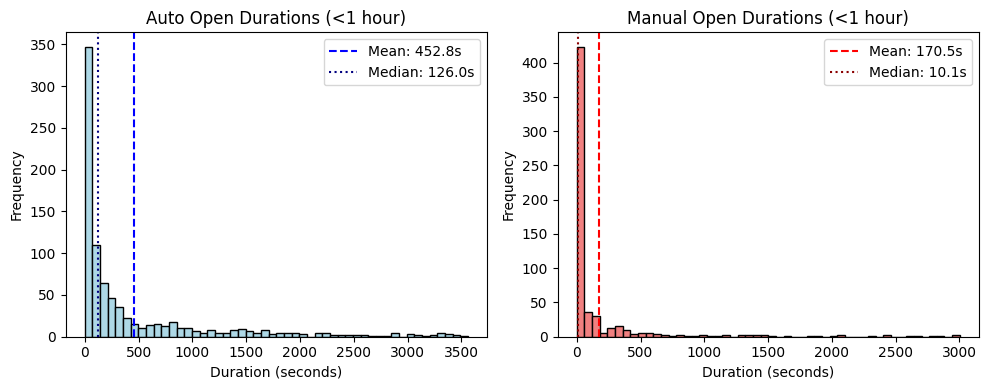

In [11]:

plt.figure(figsize=(10,4))

# Auto
plt.subplot(1, 2, 1)
plt.hist(auto_durations, bins=50, color='lightblue', edgecolor='black')


plt.axvline(auto_durations.mean(), color='blue', linestyle='--', label=f"Mean: {auto_durations.mean():.1f}s")


plt.axvline(auto_durations.median(), color='navy', linestyle=':', label=f"Median: {auto_durations.median():.1f}s")

plt.title('Auto Open Durations (<1 hour)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.legend()

# Manual
plt.subplot(1, 2, 2)
plt.hist(manual_durations, bins=50, color='lightcoral', edgecolor='black')


plt.axvline(manual_durations.mean(), color='red', linestyle='--', label=f"Mean: {manual_durations.mean():.1f}s")


plt.axvline(manual_durations.median(), color='darkred', linestyle=':', label=f"Median: {manual_durations.median():.1f}s")

plt.title('Manual Open Durations (<1 hour)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

Here I demontsrated median too because it gives better description of what "typical" session looks like because the data is heavily right-skewed meaning lots of short sessions with a few extremely long ones. So the median is more informative. Auto median is 126.0s which is greater than median of manual 10.1s

## Step 4 : I will run two tests to determine if the differences found are statistically significant

- Independent two-sample t-test

      → compares means of two groups

- Optional Mann–Whitney U test

      → compares medians (more robust when data is skewed)

In [12]:
from scipy.stats import ttest_ind, mannwhitneyu

# T-test
t_stat, p_ttest = ttest_ind(auto_durations, manual_durations, equal_var=False)
print(f"T-test p-value: {p_ttest:.5f}")

# Mann–Whitney test
u_stat, p_mwu = mannwhitneyu(auto_durations, manual_durations, alternative='two-sided')
print(f"Mann–Whitney U p-value: {p_mwu:.5f}")

if p_ttest < 0.05:
    print("The mean difference between auto and manual sessions is statistically significant.")
else:
    print("The mean difference is NOT statistically significant.")

if p_mwu < 0.05:
    print("The median difference is also statistically significant.")
else:
    print("The median difference is NOT statistically significant.")


T-test p-value: 0.00000
Mann–Whitney U p-value: 0.00000
The mean difference between auto and manual sessions is statistically significant.
The median difference is also statistically significant.


Both the t-test and Mann–Whitney U test returned p-values below 0.05, confirming that the observed difference in durations between automatically and manually opened tool windows is statistically significant and not due to random variation.